<font size=5>NFDRSV4-GSI</font><br>
W. Matt Jolly, william.jolly@usda.gov<br>
USDA Forest Service<br>
RMRS Fire Sciences Laboratory<br>
Fire, Fuel and Smoke Program<br>
5775 Hwy 10 W<br>
Missoula, MT 59808<br>


### Calculation of GSI for Golestan

In [18]:
import pandas as pd
import math
import matplotlib.pyplot as plt

### Basic met functions, photoperiod and conversions


In [38]:
## fToC Converts Fahrenheit to Celcius
## Inputs: f: Temperature in deg F
## Returns: c: Temperature in deg C
def fToc(f):
    return (f -32) * 5/9

## cTof Converts Celcius to Fahrenheit
## Inputs: c: Temperature in deg C
## Returns: f: Temperature in deg F
def cTof(c):
    return (c * 9/5) + 32

MM_2_IN = 0.0393701  # Conversion factor from mm to inches
KPH_2_MPH = 0.621371 # Conversion factor from KPH to MPH

## Calculate the Photoperiod/Daylength from latitude and day of year (yearday)
## Inputs: lat: Latitude in Degrees (90 to -90)
##         yday: Yearday (1-366)
def CalcDayl(lat,yday):
    RADPERDAY = 0.017214
    RADPERDEG = 0.01745329
    MINDECL = -0.4092797
    SECPERRAD = 13750.9871
    DAYSOFF = 10.25
    # Daylength function from MT-CLIM */
    lat = lat * RADPERDEG
    if lat > 1.5707:
        lat = 1.5707
    if lat < -1.5707:
        lat = -1.5707
    coslat = math.cos(lat)
    sinlat = math.sin(lat)

    #* calculate cos and sin of declination */
    decl = MINDECL * math.cos((yday + DAYSOFF) * RADPERDAY)
    cosdecl = math.cos(decl)
    sindecl = math.sin(decl)
    cosegeom = coslat * cosdecl
    sinegeom = sinlat * sindecl
    coshss = -(sinegeom) / cosegeom
    if coshss < -1.0:
        coshss = -1.0  # 24-hr daylight */
    if coshss > 1.0:
        coshss = 1.0    # 0-hr daylight */
    hss = math.acos(coshss)                # hour angle at sunset (radians) */
    #* daylength (seconds) */
    return 2.0 * hss * SECPERRAD

# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
# Input: tempF: Temperature in Deg F
# Return: Saturation Vapor Pressure (Pa)
def CalcVP_F(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * math.exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Input: tempC: Temperature in Deg C
# Return: Saturation Vapor Pressure (Pa)
def CalcVP_C(temp):
    tmpC =  temp
    vp = 610.7 * math.exp((17.38 * tmpC)/(239 + tmpC))
    return vp
    
# Calculate the VPD from RH and temperature
# Inputs: RH: Relative Humidity in Percent (1-100)
#         TempF: Temperature in Deg C
# Return: Vapor Pressure Deficit (Pa)
def CalcVPD_C(RH, TempC):
    vp = CalcVP_C(TempC)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd

# Calculate the VPD from RH and temperature
# Inputs: RH: Relative Humidity in Percent (1-100)
#         TempF: Temperature in Deg F
# Return: Vapor Pressure Deficit (Pa)
def CalcVPD_F(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd



#### Read the input weather data file

In [39]:
dat = pd.read_excel('GSI.xlsx')
dat['VPD'] = dat.apply(lambda row: CalcVPD_C(row['MIN HM'],row['Max temp']),axis=1)
dat['Date'] = pd.to_datetime(dat.data)

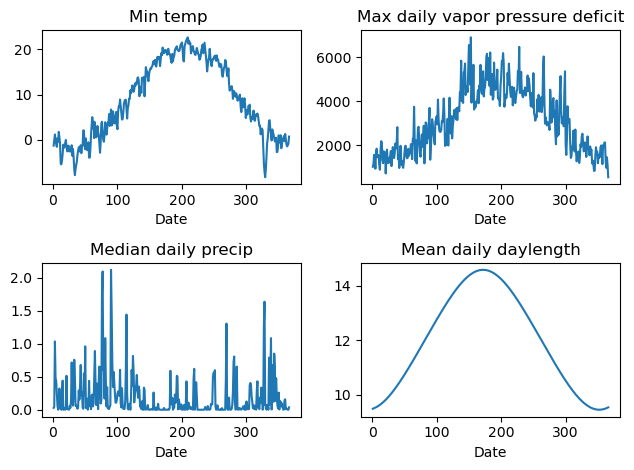

In [42]:
f,ax = plt.subplots(2,2)
dat.groupby(dat.Date.dt.dayofyear)['Min Temp'].min().plot(ax=ax[0,0],title="Min temp ")
dat.groupby(dat.Date.dt.dayofyear)['VPD'].max().plot(ax=ax[0,1],title="Max daily vapor pressure deficit")
dat.groupby(dat.Date.dt.dayofyear)['precipitation'].median().plot(ax=ax[1,0],title="Median daily precip")
dat.groupby(dat.Date.dt.dayofyear)['daylength'].mean().plot(ax=ax[1,1],title="Mean daily daylength")
f.tight_layout()

In [43]:
# A class to contains all of the parameters used to derived GSI.  This makes it easier to iterate through parameter spaces for
# for optimization
class GSILimits:
    TminLow = -2       # Lower limit for minimum temperature (C)
    TminUp = 5         # Upper limit for minimum temperature (C)
    DaylLow = 36000    # Lower limit for daylength (seconds)
    DaylUp = 39600     # Upper limit for daylength (seconds)
    VPDLow = 900       # Lower limit for VPD (pascals)
    VPDUp = 4100       # Upper limit for VPD (pascals)
    PrcpRTLow = 0    # Lower limit for running total precip (inches)
    PrcpRTUp = 0.393701  # Upper limit for running total precip (inches)... defaults to 10mm
    PrcpRTPeriod = 28  # Running total period for precipitaiton (days)
    GSIPeriod = 28     # Running average period for final GSI (days)
    GUThresh = 0.2    # Green-up threshold (dim)
    LFMMax = 200       # Maximum fuel moisture (% dry wt)
    LFMMin = 60        # Minimum fuel moisture (% dry wt)
    Lat = 45           # Station latitude (degrees)

In [44]:
# Helper function to set the GSI Limits class values based on the list of calibrated parameters
# gsilim: An instance of the GSILimits class
# gsiparams: an 11 element list of GSI parameters
# LFMMin: minimum live fuel moisture limit for model
# LFMMax: maximum live fuel moisture limit for model
# Lat: Latitude of the estimatation location (used in photoperiod calculations)
def SetGSILimits(gsilim,gsiparams,LFMMin,LFMMax, Lat):
    gsilim.TminLow = gsiparams[0] 
    gsilim.TminUp = gsiparams[1]
    gsilim.VPDLow = gsiparams[2]
    gsilim.VPDUp = gsiparams[3]
    gsilim.DaylLow = gsiparams[4]
    gsilim.DaylUp = gsiparams[5]
    gsilim.PrcpRTLow = gsiparams[6]
    gsilim.PrcpRTUp = gsiparams[7]
    gsilim.GSIPeriod = gsiparams[8]
    gsilim.GUThresh = gsiparams[9]
    gsilim.PrcpRTPeriod = gsiparams[10]
    gsilim.LFMMin = LFMMin
    gsilim.LFMMax = LFMMax
    gsilim.Lat = Lat
    return gsilim

In [45]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

In [46]:
# Function to calculate GSI, Scaled GSI and Live Fuel Moisture on a DataFrame
# df: Pandas DataFrame of daily weather data
# assumes the following labeled columns: "Tmin: minimum temperature (deg F), VPDMax: Max daily VPD (Pa)
#                                          and Prcp: 24 hour total precipitation (Inches)"
# gsilim: An instance of the GSILimits class 
# PLowLim and PUpperLim: Date range for model predictions

def CalcGSI(df,gsilim,PLowLim='2014-01-01',PUpperLim = '2020-12-31',SI=False):
    # Filter the dataset for a 5 year period
    df = df[(df['DateTime'] > PLowLim) & (df['DateTime'] <= PUpperLim)].copy()
    # Compute and store the day of the year for use in calculating Daylength
    df['JDay'] = df.DateTime.dt.dayofyear
    # Minimum Temperature
    if not SI:
        df['TminC'] =  (df.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius
    else:
        df['TminC'] =  df.Tmin
    df['TminInd'] = df.apply(lambda row: Ind(row['TminC'],gsilim.TminLow,gsilim.TminUp),axis=1)
    # Vapor Pressure Deficit
    df['VPDInd']= df.apply(lambda row: 1 - Ind(row['VPDMax'],gsilim.VPDLow,gsilim.VPDUp),axis=1)
    # Photoperiod / Daylength
    # First, calculate the Daylength for each observation day (this uses site latitude and julian day)
    df['Dayl'] = df.apply(lambda row: CalcDayl(gsilim.Lat,row['JDay']),axis=1)  
    df['DaylInd']= df.apply(lambda row: Ind(row['Dayl'],gsilim.DaylLow,gsilim.DaylUp),axis=1)
    # Running Total Precipitation
    df['Prcp_RT'] = df['Prcp'].rolling(gsilim.PrcpRTPeriod).sum()
    df['PrcpInd'] = df.apply(lambda row: Ind(row['Prcp_RT'],gsilim.PrcpRTLow,gsilim.PrcpRTUp),axis=1)

    #################################################################                  
    # Daily GSI for four ramp model
    df['iGSI_PE'] = df['TminInd'] * df['VPDInd'] * df['DaylInd'] * df['PrcpInd']
    # Smoothed GSI (running average over the GSIPeriod)
    df['GSI_PE'] = df['iGSI_PE'].rolling(gsilim.GSIPeriod).mean()
    # Rescale the final GSI time series
    df['GSI_PE_RS'] = df['GSI_PE']/ df['GSI_PE'].quantile(1)

    # Calculate LFMC from Rescaled GSI
    df['LFMC'] = df.apply(lambda row: CalcLFMFromGSI(row['GSI_PE_RS'],gsilim.GUThresh,gsilim.LFMMin, gsilim.LFMMax),axis=1)
    return df


In [47]:
## Function to transform GSI to LFMC
def CalcLFMFromGSI(gsi,GUThresh,LFMMin,LFMMax):
    m = (LFMMax - LFMMin) / (1 - GUThresh)
    b = LFMMax - m
    # Scale GSI between min and max LFMC if gsi is above the green-up threshold
    if(gsi >= GUThresh):
        LFM = m*gsi + b
    # Below the Green-up Threshold, set the value to minimum LFM
    else:
        LFM = LFMMin
    return(LFM)

In [48]:
dat.columns


Index(['data', 'DAY', 'mean Temp', 'Min Temp', 'Max temp', 'MIN HM', 'maxHM',
       'mean HM', 'windspeed', 'wind direction', 'precipitation', 'daylength',
       'vpd', 'ivpd', 'itmin', 'iphoto', 'GSI', 'VPD', 'Date'],
      dtype='object')

In [49]:
GU = 0.2
Days = 28
Lat = 38    # Just guessing, this is the site location latitude in decimal degrees
defParams = [-2, 5, 900, 4100, 36000, 39600, 10, 20, Days,GU,Days]

In [53]:
dat.Date.max()

Timestamp('2023-07-23 00:00:00')

In [54]:
PLowLim='2012-01-01'
PUpperLim = '2022-12-31'

# Label the DataFrame columns so they match the GSI function
Temp = dat.rename(columns={"Date": "DateTime","Min Temp": "Tmin", "VPD": "VPDMax", "precipitation":"Prcp"})
# Lookup the appropriate live fuel moisture ranges
LFMMin,LFMMax = [30,250]#GetLFMRange(LFMObs,UseLFMMinMax,Herb)
gsilim = GSILimits
newgsilim = SetGSILimits(gsilim,defParams,LFMMin,LFMMax,Lat)

# Calculate the GSI
t = CalcGSI(Temp,newgsilim,PLowLim='2014-01-01',PUpperLimSI=True)
    

Text(0, 0.5, 'Running total precip (mm)')

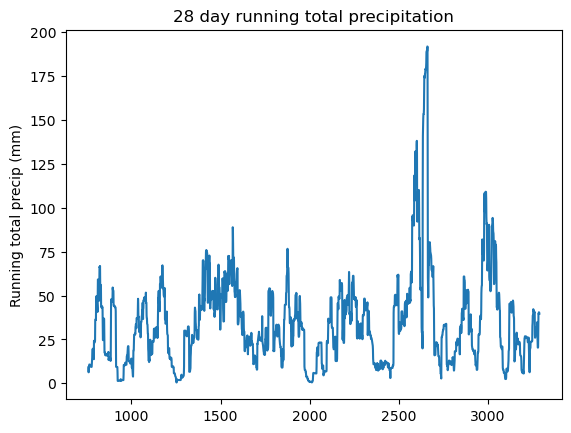

In [55]:
f,ax = plt.subplots()
t.Prcp_RT.plot(title="28 day running total precipitation",ax=ax)
ax.set_ylabel('Running total precip (mm)')


In [33]:
t.Prcp_RT.quantile([0.05,0.25])

0.05     4.177115
0.25    16.006786
Name: Prcp_RT, dtype: float64

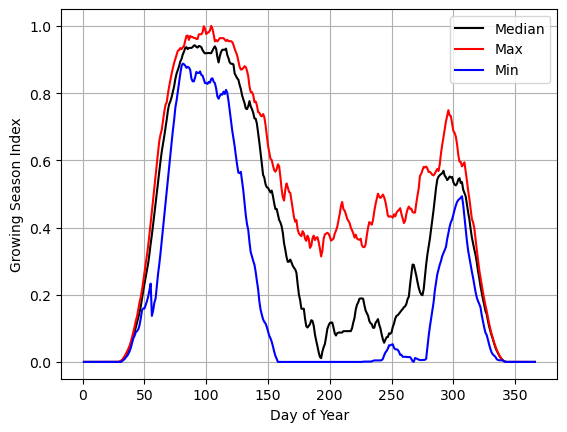

In [36]:
f,ax = plt.subplots()
t.GSI_PE_RS.groupby(t.DateTime.dt.dayofyear).median('Date').plot(ax=ax,color='black',label='Median',legend=True)
t.GSI_PE_RS.groupby(t.DateTime.dt.dayofyear).max('Date').plot(ax=ax,color='red',label='Max',legend=True)
t.GSI_PE_RS.groupby(t.DateTime.dt.dayofyear).min('Date').plot(ax=ax,color='blue',label='Min',legend=True)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Growing Season Index")
ax.grid(True)

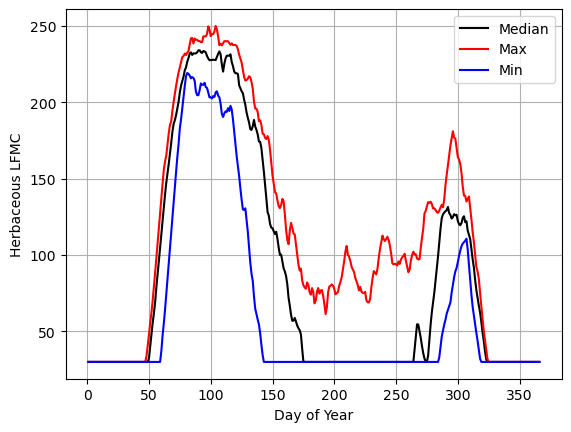

In [37]:
f,ax = plt.subplots()
t.LFMC.groupby(t.DateTime.dt.dayofyear).median('Date').plot(ax=ax,color='black',label='Median',legend=True)
t.LFMC.groupby(t.DateTime.dt.dayofyear).max('Date').plot(ax=ax,color='red',label='Max',legend=True)
t.LFMC.groupby(t.DateTime.dt.dayofyear).min('Date').plot(ax=ax,color='blue',label='Min',legend=True)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Herbaceous LFMC")
ax.grid(True)